<center>
<img src="../../img/ods_stickers.jpg">
## Open Machine Learning Course
</center>
<center>Authors: Ilya Baryshnikov, Data Scientist at ivi.ru, Yury Kashnitskiy, Data Scientist at Mail.Ru Group

This material is subject to the terms and conditions of the license [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Free use is permitted for any non-comercial purpose with an obligatory indication of the names of the authors and of the source.

# <center>Solution to Assignment # 2</center>
## <center>Analyzing cardiovascular disease data</center>  

In this assignment, you will answer questions about a dataset on cardiovascular disease. You don't need to download the data: it is already in the repository. Fill in the code in cells with the "Your code here" placeholder. Then answer the questions in the [form](https://drive.google.com/open?id=1IpLdIncbGKLvaAAE0VBB2EBuyrJDmzUrPr4pBl8k7cI).

#### Problem

Predict presence or absence of cardiovascular disease (CVD) using the patient examination results.

#### Data description

There are 3 types of input features:

- *Objective*: factual information;
- *Examination*: results of medical examination;
- *Subjective*: information given by the patient.

| Feature | Variable Type | Variable      | Value Type |
|---------|--------------|---------------|------------|
| Age | Objective Feature | age | int (days) |
| Height | Objective Feature | height | int (cm) |
| Weight | Objective Feature | weight | float (kg) |
| Gender | Objective Feature | gender | categorical code |
| Systolic blood pressure | Examination Feature | ap_hi | int |
| Diastolic blood pressure | Examination Feature | ap_lo | int |
| Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
| Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
| Smoking | Subjective Feature | smoke | binary |
| Alcohol intake | Subjective Feature | alco | binary |
| Physical activity | Subjective Feature | active | binary |
| Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

All of the dataset values were collected at the moment of medical examination.

Let's get to know our data by performing a preliminary data analysis.

#  Part 1. Preliminary data analysis

First, we will initialize the environment:

In [1]:
# Import all required modules
import pandas as pd
import numpy as np

# Disable warnings
import warnings
warnings.filterwarnings("ignore")

# Import plotting modules
import seaborn as sns
sns.set()
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
%matplotlib inline

You should use the `seaborn` library for visual analysis, so let's set it up too:

In [2]:
# Tune the visual settings for figures in `seaborn`
sns.set_context(
    "notebook", 
    font_scale=1.5,       
    rc={ 
        "figure.figsize": (11, 8), 
        "axes.titlesize": 18 
    }
)

from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8

To make it simple, we will work only with the training part of the dataset:

In [3]:
df = pd.read_csv('../../data/mlbootcamp5_train.csv', sep=';')
print('Dataset size: ', df.shape)
df.head()

Dataset size:  (70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


It would be instructive to peek into the values of our variables.
 
Let's convert the data into *long* format and depict the value counts of the categorical features using [`factorplot()`](https://seaborn.pydata.org/generated/seaborn.factorplot.html).

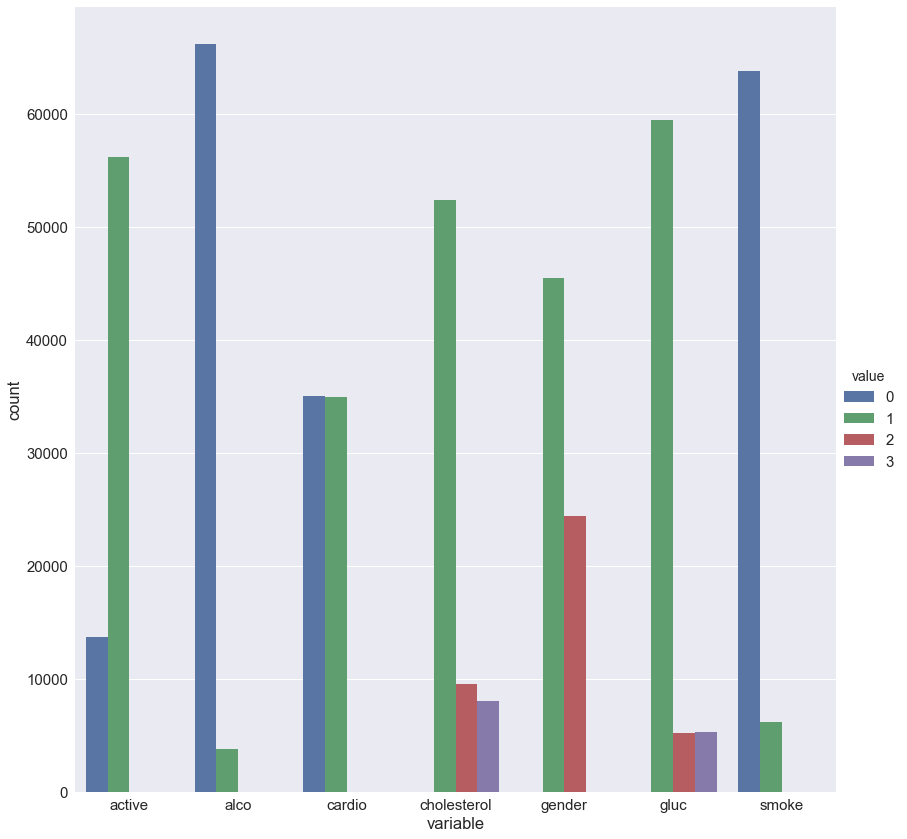

In [4]:
df_uniques = pd.melt(frame=df, value_vars=['gender','cholesterol', 
                                           'gluc', 'smoke', 'alco', 
                                           'active', 'cardio'])
df_uniques = pd.DataFrame(df_uniques.groupby(['variable', 
                                              'value'])['value'].count()) \
    .sort_index(level=[0, 1]) \
    .rename(columns={'value': 'count'}) \
    .reset_index()

sns.factorplot(x='variable', y='count', hue='value', 
               data=df_uniques, kind='bar', size=12);

We can see that the target classes are balanced. That's great!

Let's split the dataset by target values: sometimes you can immediately spot the most significant feature on the plot.

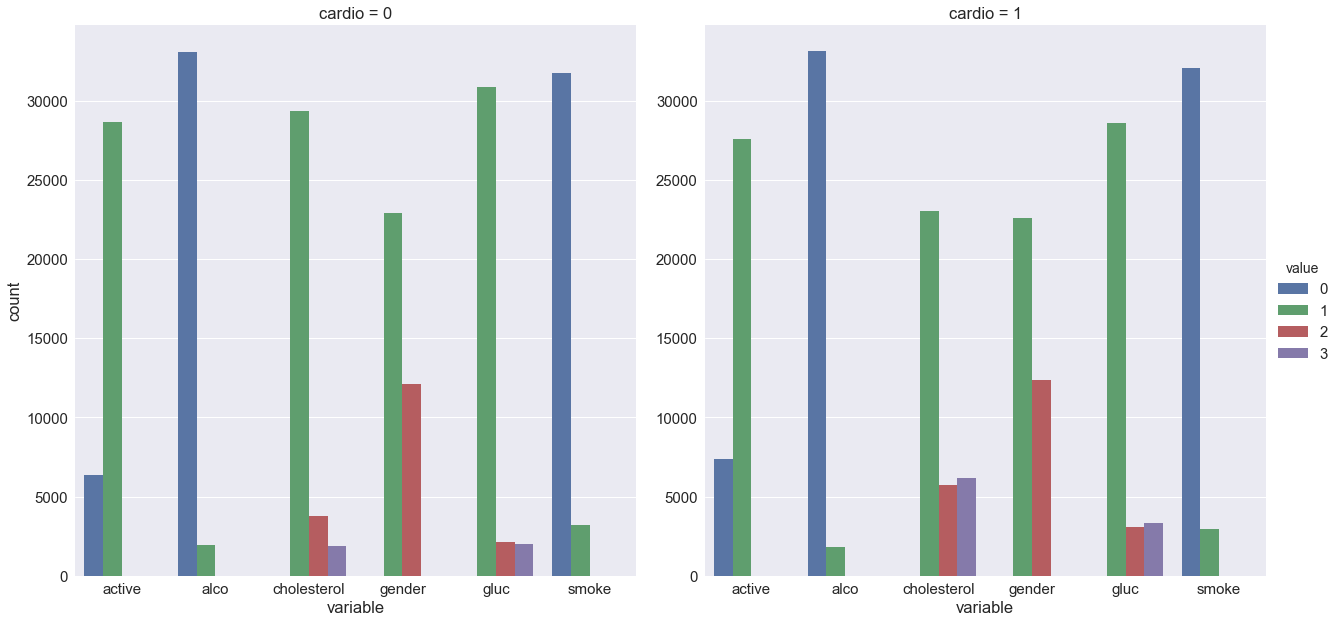

In [5]:
df_uniques = pd.melt(frame=df, value_vars=['gender','cholesterol', 
                                           'gluc', 'smoke', 'alco', 
                                           'active'], 
                     id_vars=['cardio'])
df_uniques = pd.DataFrame(df_uniques.groupby(['variable', 'value', 
                                              'cardio'])['value'].count()) \
    .sort_index(level=[0, 1]) \
    .rename(columns={'value': 'count'}) \
    .reset_index()

sns.factorplot(x='variable', y='count', hue='value', 
               col='cardio', data=df_uniques, kind='bar', size=9);

You can see that the target variable greatly affects the distribution of cholesterol and glucose levels. Is this a coincidence?

Now, let's calculate some statistics for the feature unique values:

In [6]:
for c in df.columns:
    n = df[c].nunique()
    print(c)
    if n <= 3:
        print(n, sorted(df[c].value_counts().to_dict().items()))
    else:
        print(n)
    print(10 * '-')

id
70000
----------
age
8076
----------
gender
2 [(1, 45530), (2, 24470)]
----------
height
109
----------
weight
287
----------
ap_hi
153
----------
ap_lo
157
----------
cholesterol
3 [(1, 52385), (2, 9549), (3, 8066)]
----------
gluc
3 [(1, 59479), (2, 5190), (3, 5331)]
----------
smoke
2 [(0, 63831), (1, 6169)]
----------
alco
2 [(0, 66236), (1, 3764)]
----------
active
2 [(0, 13739), (1, 56261)]
----------
cardio
2 [(0, 35021), (1, 34979)]
----------


In the end, we have:
- 5 numerical features (excluding *id*);
- 7 categorical features;
- 70000 records in total.

## 1.1. Basic observations

**Question 1.1. (1 point). How many men and women are present in this dataset? Values of the `gender` feature were not expailned (whether "1" stands for women or men) – figure this out by looking analyzing height, reasonably assuming that on average men are taller. **
1. 45530 women и 24470 men
2. 45530 men и 24470 women
3. 45470 women и 24530 men
4. 45470 men и 24530 women

**Answer:** 1.

### Solution:

Let's calculate average height for both values of `gender`:

In [7]:
df.groupby('gender')['height'].mean()

gender
1    161.355612
2    169.947895
Name: height, dtype: float64

161 cm and almost 170 cm on average, so we make a conclusion that gender=1 represents females, and gender=2 – males. So the sample contains 45530 women и 24470 men.

**Question 1.2. (1 point). Who more often report consuming alcohol - men or women?**
1. women
2. men

**Answer:** 2.

### Solution:

In [8]:
df.groupby('gender')['alco'].mean()

gender
1    0.025500
2    0.106375
Name: alco, dtype: float64

Well... obvious :)

**Question 1.3. (1 point). What's the rounded difference between the percentages of smokers among men and women?**
1. 4
2. 16
3. 20
4. 24

**Answer:** 3.

### Solution:

In [9]:
df.groupby('gender')['smoke'].mean()

gender
1    0.017856
2    0.218880
Name: smoke, dtype: float64

In [10]:
round(100 * (df.loc[df['gender'] == 2, 'smoke'].mean() - df.loc[df['gender'] == 1, 'smoke'].mean()))

20

**Question 1.4. (1 point). What's the rounded difference between median values of age for smokers and non-smokers? You'll need to figure out the units of feature `age` in this dataset.**

1. 5
2. 10
3. 15
4. 20

**Answer:** 4.

### Solution:

Age is given here in days.

In [11]:
df.groupby('smoke')['age'].median() / 365.25

smoke
0    53.995893
1    52.361396
Name: age, dtype: float64

Median age of smokers is 52.4 years, for non-smokers it's 54. We see that the correct answer is 20 months. But here is a way to calculate it exactly:

In [12]:
(df[df['smoke'] == 0]['age'].median() - 
 df[df['smoke'] == 1]['age'].median()) / 365.25 * 12

19.613963039014372

## 1.2. Risk maps
### Task:

On the web site of European Society of Cardiology, a [SCORE scale](https://www.escardio.org/Education/Practice-Tools/CVD-prevention-toolbox/SCORE-Risk-Charts) is given. It is used for calculating the risk of death from a cardiovascular decease in the next 10 years. Here it is:
<img src='../../img/SCORE2007-eng.png' width=70%>

Let's take a look at the upper-right rectangle showing a subset of smoking men aged from 60 to 65. (It's not obvious, but the values in figure represent the upper boundary).

We see a value 9 in the lower-left corner of the rectangle and 47 in the upper-right. This means that for people in this gender-age group whose systolic pressure is less than 120 the risk of a CVD is estimated to be 5 times lower than for those with the pressure in the interval [160,180).

Let's calculate the same ratio, but with our data.

Clarifications:
- Calculate ``age_years`` feature – rounded age in years. For this task, select people aged from 60 to 64 inclusive.
- Cholesterol level categories in the figure and in our data are different. In the figure, the values of ``cholesterol`` feature are as follows: 4 mmol/l $\rightarrow$ 1, 5-7 mmol/l $\rightarrow$ 2, 8 mmol/l $\rightarrow$ 3.

**Question 1.5. (2 points). Calculate fractions of ill people (with CVD) in two segments described above. What's the quotient of these two fractions?**

1. 1
2. 2
3. 3
4. 4

**Answer:** 3.

### Solution:

In [13]:
df['age_years'] = (df['age'] / 365.25).round().astype('int')

In [14]:
df['age_years'].max()

65

The oldest people in the sample are aged 65. Concidence? Don't think so! Let's select smoking men of age [60,64].

In [15]:
smoking_old_men = df[(df['gender'] == 2) & (df['age_years'] >= 60)
                    & (df['age_years'] < 65) & (df['smoke'] == 1)]

If cholesterol level in this age group is 1, and systolic pressure is below 120, then the proportion of people with  CVD is 26%.

In [16]:
smoking_old_men[(smoking_old_men['cholesterol'] == 1) &
               (smoking_old_men['ap_hi'] < 120)]['cardio'].mean()

0.2631578947368421

If, however, cholesterol level in this age group is 3, and systolic pressure is from 160 to 180, then the proportion of people with a CVD is 86%.

In [17]:
smoking_old_men[(smoking_old_men['cholesterol'] == 3) &
               (smoking_old_men['ap_hi'] >= 160) &
               (smoking_old_men['ap_hi'] < 180)]['cardio'].mean()

0.8636363636363636

As a result, the difference is approximately 3-fold. Not 5-fold, as the SCORE scale tells us, but it's possible that the SCORE risk of CVD is nonlinearly dependent on the proportion of ill people in the given age group.

## 1.3. Analyzing BMI
### Task:

Create a new feature – BMI ([Body Mass Index](https://en.wikipedia.org/wiki/Body_mass_index)). To do this, divide weight in kilogramms by the square of height in meters. Normal BMI values are said to be from 18.5 to 25. 

**Question 1.6. (2 points). Choose the correct statements:.**

1. Median BMI in the sample is within boundaries of normal values.
2. Women's BMI is on average higher then men's.
3. Healthy people have, on average, higher BMI than ill people.
4. In the segment of healthy and non-drinking men BMI is closer to the norm than in the segment of healthy and non-drinking women

**Answer:** 2 and 4

### Solution:

In [18]:
df['BMI'] = df['weight'] / (df['height'] / 100) ** 2

In [19]:
df['BMI'].median()

26.374068120774975

First statement is incorrect since median BMI exceeds the norm of 25 points.

In [20]:
df.groupby('gender')['BMI'].median()

gender
1    26.709402
2    25.910684
Name: BMI, dtype: float64

Seconds statement is correct – women's BMI is higher on average.

Third statement is incorrect.

In [21]:
df.groupby(['gender', 'alco', 'cardio'])['BMI'].median().to_frame()

BMI
gender alco cardio           
1      0    0       25.654372
            1       27.885187
       1    0       27.885187
            1       30.110991
2      0    0       25.102391
            1       26.674874
       1    0       25.351541
            1       27.530797

Comparing BMI values in rows where `alco=0` and `cardio=0`, we see that the last statement is correct.

## 1.4. Cleaning data

### Task:
We can notice, that the data is not perfect. It contains much of "dirt" and inaccuracies. We'll see it better when we do data visualization.

Filter out the following patient segments (that we consider to have erroneous data)

- diastilic pressure is higher then systolic. 
- height is strictly less than 2.5%-percentile (use `pd.Series.quantile`. If not familiar with it – please read the docs)
- height is strictly more than 97.5%-percentile
- weight is strictly less then 2.5%-percentile
- weight is strictly more than 97.5%-percentile

This is not all we can do to clean the data, but let's stop here by now.

**Question 1.7. (2 points). How many percents of data (rounded) did we throw away?**

1. 8
2. 9
3. 10
4. 11

**Answer:** 3

### Solution:

In [22]:
filtered_df = df[(df['ap_lo'] <= df['ap_hi']) & 
                 (df['height'] >= df['height'].quantile(0.025)) &
                 (df['height'] <= df['height'].quantile(0.975)) &
                 (df['weight'] >= df['weight'].quantile(0.025)) & 
                 (df['weight'] <= df['weight'].quantile(0.975))]
print(filtered_df.shape[0] / df.shape[0])

0.9037


We've thrown out about 10% of the original data.

# Part 2. Visual data analysis

## 2.1. Correlation matrix visualization

To understand the features better, you can create a matrix of the correlation coefficients between the features. Use the initial dataset (non-filtered).

### Task:

Plot a correlation matrix using [`heatmap()`](http://seaborn.pydata.org/generated/seaborn.heatmap.html). You can create the matrix using the standard `pandas` tools with the default parameters.

### Solution:

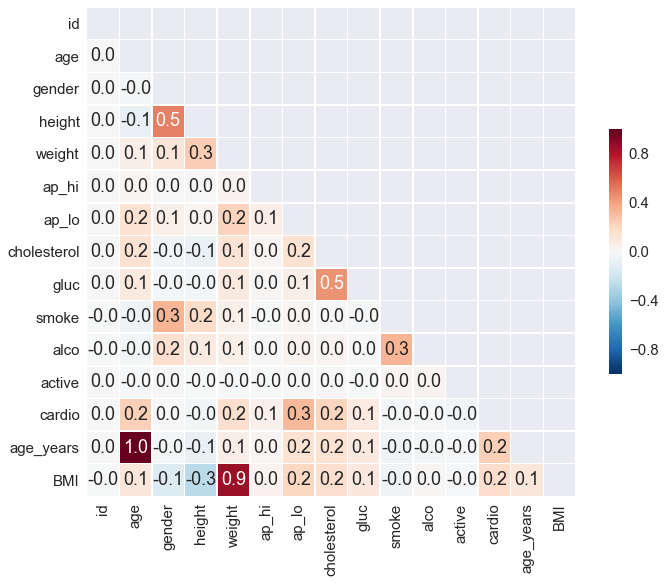

In [30]:
# Calculate the correlation matrix
df = filtered_df.copy()

corr = df.corr(method='pearson')

# Create a mask to hide the upper triangle of the correlation matrix (which is symmetric)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(12, 9))

sns.heatmap(corr, mask=mask, vmax=1, center=0, annot=True, fmt='.1f',
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

** Question 2.1. (1 point).** Which pair of features has the strongest Pearson's correlation with the *gender* feature?

1. Cardio, Cholesterol
2. Height, Smoke
3. Smoke, Alco
4. Height, Weight

**Answer:** 2.

## 2.2. Height distribution of men and women

From our exploration of the unique values we know that the gender is encoded by the values *1* and *2*. And though you don't have a specification of how these values correspond to men and women, you can figure that out graphically by looking at the mean values of height and weight for each value of the *gender* feature.

### Task:

Create a violin plot for the height and gender using [`violinplot()`](https://seaborn.pydata.org/generated/seaborn.violinplot.html). Use the parameters:
- `hue` to split by gender;
- `scale` to evaluate the number of records for each gender.

In order for the plot to render correctly, you need to convert your `DataFrame` to *long* format using the `melt()` function from `pandas`. Here is [another example](https://stackoverflow.com/a/41575149/3338479) of this.

### Solution:

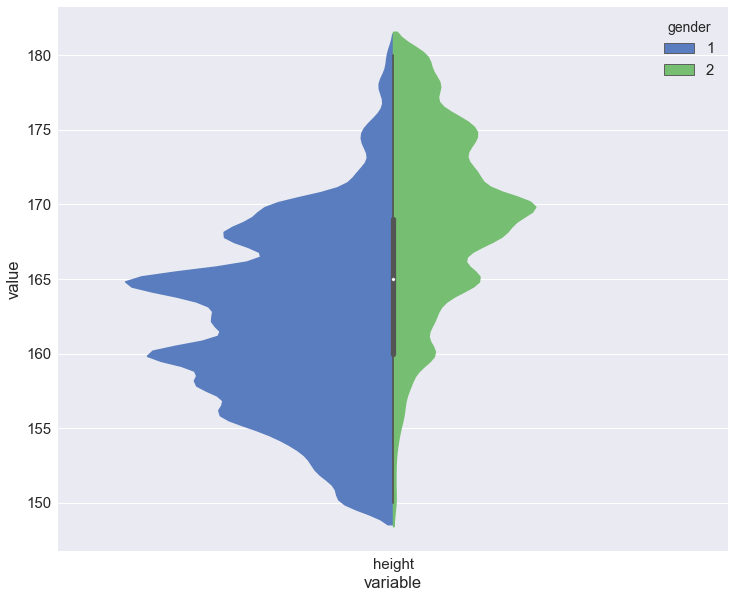

In [31]:
df_melt = pd.melt(frame=df, value_vars=['height'], id_vars=['gender'])

plt.figure(figsize=(12, 10))
ax = sns.violinplot(
    x='variable', 
    y='value', 
    hue='gender', 
    palette="muted", 
    split=True, 
    data=df_melt, 
    scale='count',
    scale_hue=False
)

### Task:

Create two [`kdeplot`](https://seaborn.pydata.org/generated/seaborn.kdeplot.html)s of the *height* feature for each gender on the same chart. You will see the difference between the genders more clearly, but you will be unable to evaluate the number of records in each of them.

### Solution:

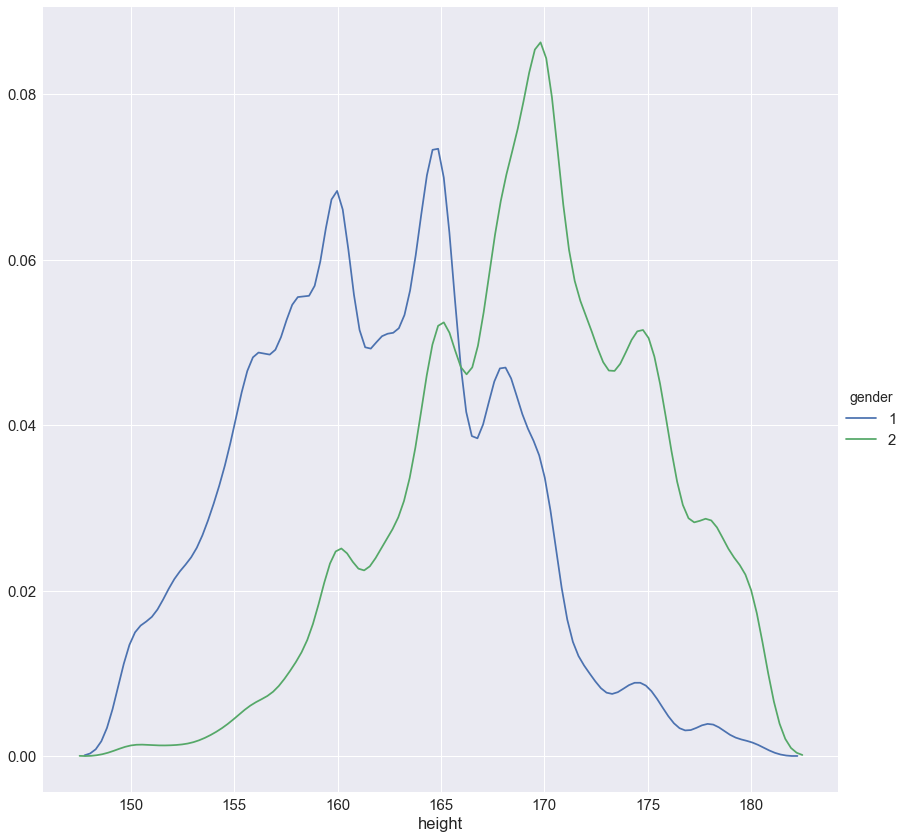

In [32]:
sns.FacetGrid(df, hue="gender", size=12) \
   .map(sns.kdeplot, "height").add_legend();

## 2.3. Rank correlation

In most cases, *the Pearson coefficient of linear correlation* is more than enough to discover patterns in data. 
But let's go a little further and calculate a [rank correlation](https://en.wikipedia.org/wiki/Rank_correlation). It will help us to identify such feature pairs in which the lower rank in the variational series of one feature always precedes the higher rank in the another one (and we have the opposite in the case of negative correlation).

### Task:

Calculate and plot a correlation matrix using the [Spearman's rank correlation coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient).

### Solution:

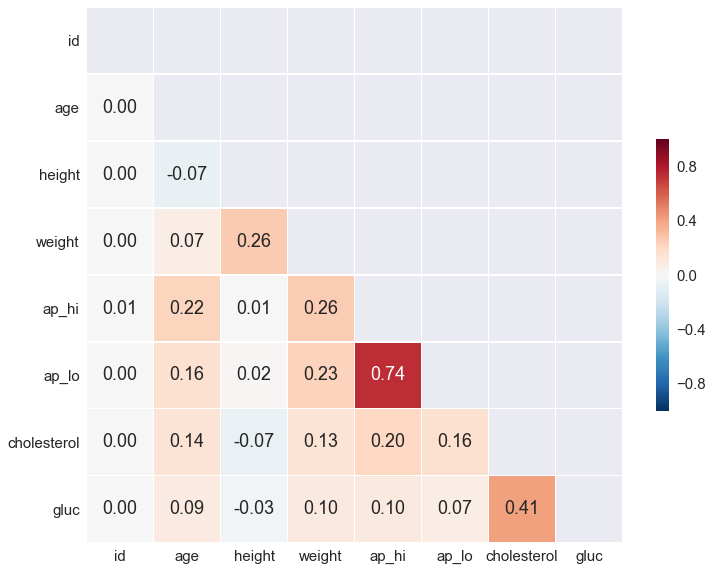

In [33]:
# Calculate the correlation matrix
corr = df[['id', 'age', 'height', 'weight', 
           'ap_hi', 'ap_lo', 'cholesterol', 
           'gluc']].corr(method='spearman')

# Create a mask to hide the upper triangle of the correlation matrix (which is symmetric)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(12, 10))

# Plot the heatmap using the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, vmax=1, center=0, annot=True, fmt='.2f',
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

**Question 2.2. (1 point).** Which pair of features has the strongest Spearman correlation?

1. Height, Weight
2. Age, Weight
3. Cholesterol, Gluc
4. Cardio, Cholesterol
5. Ap_hi, Ap_lo
6. Smoke, Alco

**Answer:** 5.

**Question 2.3. (1 point).** Why does these features have strong rank correlation?

1. Inaccuracies in the data (data acquisition errors).
2. Relation is wrong, these features should not be related.
3. Nature of the data.

**Answer:** 3.

## 2.4. Age

Previously we calculated the age of the respondents in years at the moment of examination.

### Task:

Create a *count plot* using [`countplot()`](http://seaborn.pydata.org/generated/seaborn.countplot.html), with the age on the *X* axis and the number of people on the *Y* axis. Each value of the age should have two columns corresponding to the numbers of people of this age for each *cardio* class.

### Solution:

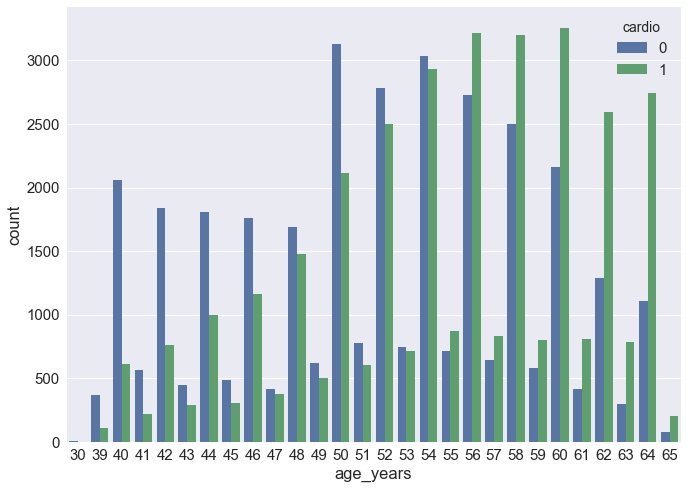

In [29]:
sns.countplot(x="age_years", hue='cardio', data=df);

**Question 2.4. (1 point).** At what age does the number of people with CVD outnumber the number of people without CVD for the first time?

1. 44
2. 55
3. 64
4. 70

**Answer:** 2.